In [1]:
import matplotlib.pyplot as plt
from matplotlib.container import BarContainer
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
from os import listdir
import os
import matplotlib.patches as mpatches
import json

from plot_utils import *

In [2]:
DATASET = "DTFit"
TASKSET = "MAIN" # "MAIN" "GENERATION" "QUERY_COMPARISON"

In [3]:
if TASKSET == "MAIN":
    task_order = ['logprobs',
                  'sentence_comparison',
                  'sentence_comparison_metaInstruct',
                  # 'word_comparison',
                  'sentence_judge_generation_likert',
                  'sentence_judge']
    FREE_CONSTRAINED_SEPARATED = False
elif TASKSET == "GENERATION":
    task_order = ['logprobs',
                   'sentence_comparison_generation_1vs2',
                   'sentence_judge_generation_likert']
    FREE_CONSTRAINED_SEPARATED = True
elif TASKSET == "QUERY_COMPARISON":
    task_order = ['sentence_comparison']

BETTER_TASK_NAMES = {
    'logprobs' : "Log Likelihood",
    'sentence_comparison' : 'Sentence Choice I',
    'sentence_comparison_metaInstruct' : 'Sentence Choice II',
    'word_comparison' : 'Word Comparison',
    'sentence_judge_generation_likert' : 'Likert Scoring\nGeneration',
    'sentence_judge' : 'Sentence Judgment'
}

In [4]:
MODEL_LIST = [elm for elm in PRETTYNAMES.keys() if elm != "human"]

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [6]:
def read_data(folder):
    # Initialize list of dataframes that we will concatenate.]
    task = folder.split("/")[-1]
    all_data = []
    
    # Get list of all JSON results files in the folder.
    files_to_read = [f for f in listdir(folder) if f.endswith(".json")]

    # Read each file into a single dataframe.
    for f in files_to_read:
        # Subset for current dataset!
        if not DATASET in f:
            continue
        with open(folder + "/" + f, "r") as fp:
            data = json.load(fp)
        results = pd.DataFrame(data["results"])
        for k, v in data["meta"].items():
            if not isinstance(v, list):
                results[k] = v
        results["corpus"] = f.split("_")[0]
        results["model"] = f.split("_")[1]
        results["task"] = task
        if not "comparison" in task:
            results["option_order"] = "noOrder"
        if task == "sentence_comparison":
            results["query"] = " ".join(f.split("q=")[1].split("_")[0].split("+"))
        all_data.append(results)

    if all_data == []:
        print(f"No models computed on benchmark {folder} yet!")
        return
    df = pd.concat(all_data)
    return df

In [7]:
# Read results for all tasks.
RESULT_DIR = f"../results"
TASKS = []
for dir_name in os.listdir(RESULT_DIR):
    TASKS.append(dir_name)
TASKS

['2023_results_prompting',
 'logprob_critical_word',
 'logprobs',
 'logprobs_critical_word',
 'sentence_comparison',
 'sentence_comparison_generation_1vs2',
 'sentence_judge',
 'sentence_judge_generation_likert',
 'word_comparison']

In [8]:
RESULTS = {task: read_data(f"{RESULT_DIR}/{task}") for task in TASKS}
RESULTS

No models computed on benchmark ../results/2023_results_prompting yet!
No models computed on benchmark ../results/logprob_critical_word yet!
No models computed on benchmark ../results/logprobs_critical_word yet!


/om2/vast/evlab/ckauf/anaconda310/envs/llm-plaus-prob/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)


{'2023_results_prompting': None,
 'logprob_critical_word': None,
 'logprobs':      item_id                             good_sentence  \
 0          1                  The actor won the award.   
 1          2              The anchorman told the news.   
 2          3                The animal found the food.   
 3          4               The ant stacked the supply.   
 4          5   The archeologist examined the epigraph.   
 ..       ...                                       ...   
 390      393  The witness explained the circumstances.   
 391      394           The witness reported the crime.   
 392      395                The woman carried the bag.   
 393      396                 The woman opened the bag.   
 394      397            The woman painted the toenail.   
 
                             bad_sentence  logprob_of_good_sentence  \
 0              The actor won the battle.                -67.945444   
 1        The anchorman told the parable.                -73.403885   


# Plot for one dataset logprobs vs. other metrics

In [11]:
import re
def extract_single_number(input_string):
    # Find all sequences of digits in the string
    numbers = re.findall(r'\d+', input_string)

    # Return the single number or None if there are multiple numbers
    return numbers[0] if len(numbers) == 1 else None

In [12]:
def preprocess_free_generation_dfs(free_df, task):
    filtered_df = free_df.copy()

    if task == "sentence_comparison_generation_1vs2":
        # subset to see if it contains continuation
        filtered_df = filtered_df[(filtered_df["contains_pattern"] == True)]
        filtered_df['generation'] = filtered_df['generation'].apply(extract_single_number)
        filtered_df = filtered_df[filtered_df['generation'].notna()]
    else:
        try:
            # subset to see if it contains continuation
            filtered_df = filtered_df[(filtered_df["bad_continuation_contains_pattern"] == True) & \
                                      (filtered_df["good_continuation_contains_pattern"] == True)]
            filtered_df['good_generation'] = filtered_df['good_generation'].apply(extract_single_number)
            filtered_df['bad_generation'] = filtered_df['bad_generation'].apply(extract_single_number)
            filtered_df = filtered_df[(filtered_df['good_generation'].notna()) & \
                                      (filtered_df['bad_generation'].notna())]
        except:
            filtered_df['good_generation'] = filtered_df['good_generation'].apply(extract_single_number)
            filtered_df['bad_generation'] = filtered_df['bad_generation'].apply(extract_single_number)
            filtered_df = filtered_df[(filtered_df['good_generation'].notna()) & \
                                      (filtered_df['bad_generation'].notna())]

    if len(filtered_df) == 0:
        print("WATCH OUT!! Filtering resulted in no values")
        
    return filtered_df

In [13]:
def compute_accuracy_metric(result_df, task):
    out_df = result_df.copy()
    initial_length = len(out_df)
    # Drop empty columns
    out_df = out_df.dropna(axis=1, how='all')
    # Drop empty rows
    out_df = out_df.dropna(axis=0, how='all')
    after_drop_length = len(out_df)
    if initial_length - after_drop_length != 0:
        print(f"Dropped {initial_length - after_drop_length} rows with NA values")

    # Balanced accuracy: (TPR+TNR)/2
    def _balanced_accuracy(rows):
        tp = rows.model_prefers_yes_good.mean()
        tn = rows.model_prefers_no_bad.mean()
        return np.mean([tp, tn])
    
    if task == "logprobs":
        out_df["Accuracy"] = out_df.apply(
            lambda row: 1 if row.logprob_of_good_sentence > row.logprob_of_bad_sentence else 0, axis=1)

    elif task == "logprobs_cricital_word":
        raise NotImplementedError("Not for this task")
    
    elif task == "sentence_judge": #continuation here is "yes"/"no"
        # True positive
        out_df["model_prefers_yes_good"] = out_df.apply(
            lambda row: row.logprob_of_yes_good_sentence > row.logprob_of_no_good_sentence,
            axis=1
        )
        # True negative
        out_df["model_prefers_no_bad"] = out_df.apply(
            lambda row: row.logprob_of_no_bad_sentence > row.logprob_of_yes_bad_sentence,
            axis=1
        )
        # False positive
        out_df["model_prefers_yes_bad"] = out_df.apply(
            lambda row: row.logprob_of_yes_bad_sentence > row.logprob_of_no_bad_sentence,
            axis=1
        )
        # False negative
        out_df["model_prefers_no_good"] = out_df.apply(
            lambda row: row.logprob_of_no_good_sentence > row.logprob_of_yes_good_sentence,
            axis=1
        )

        out_df["Accuracy"] = out_df.apply(
            lambda row: 1 if ((row.model_prefers_yes_good == 1) & (row.model_prefers_no_bad == 1)) else 0, axis=1)
        

    elif task == "sentence_comparison": #continuation here is "1"/"2" #note I messed up here with the task;
        # that's why the two cases, fix this in the jsons
        try:
            out_df["Accuracy"] = out_df.apply(
                lambda row: 1 if row.logprob_of_good_continuation > row.logprob_of_bad_continuation else 0, axis=1)
        except:
            out_df["Accuracy"] = out_df.apply(
                lambda row: 1 if row.logprob_of_good_cont > row.logprob_of_bad_cont else 0, axis=1)

    elif task == "sentence_comparison_generation_1vs2":
        if "free" in out_df.gen_type.unique():
            free_df = out_df[out_df.gen_type == "free"]
            free_df = preprocess_free_generation_dfs(free_df, task)
            constrained_df = out_df[out_df.gen_type == "constrained"]
            out_df = pd.concat([free_df, constrained_df])
        if len(out_df) == 0:
            print("Filtering resulted in no values")
        else:
            out_df["Accuracy"] = out_df.apply(
                lambda row: 1 if row.generation == row.good_sentence_nr else 0, axis=1)

    elif task == "sentence_judge_generation_likert":
        if "free" in out_df.gen_type.unique():
            free_df = out_df[out_df.gen_type == "free"]
            free_df = preprocess_free_generation_dfs(free_df, task)
            constrained_df = out_df[out_df.gen_type == "constrained"]
            out_df = pd.concat([free_df, constrained_df])
        if len(out_df) == 0:
            print("Filtering resulted in no values")
        else:
            out_df["Accuracy"] = out_df.apply(
                lambda row: 1 if row.good_generation > row.bad_generation else 0, axis=1)

    else:
        raise ValueError("Not implemented")
    
    return out_df

In [14]:
df_list = []
for task, result_df in RESULTS.items():
    if not task in task_order:
        continue
    if result_df is None:
        continue
    print(task)
    result_df = result_df[result_df.corpus == DATASET]
    result_df = result_df[result_df.model.isin(MODEL_LIST)]
    if len(result_df) == 0:
        print(f"{DATASET} was not computed for task {task} yet")
        continue
    out_df = compute_accuracy_metric(result_df, task)
    df_list.append(out_df)
    print("****")

logprobs
****
sentence_comparison
****
sentence_judge
****
sentence_judge_generation_likert
****


In [15]:
df_list

[     item_id                             good_sentence  \
 0          1                  The actor won the award.   
 1          2              The anchorman told the news.   
 2          3                The animal found the food.   
 3          4               The ant stacked the supply.   
 4          5   The archeologist examined the epigraph.   
 ..       ...                                       ...   
 390      393  The witness explained the circumstances.   
 391      394           The witness reported the crime.   
 392      395                The woman carried the bag.   
 393      396                 The woman opened the bag.   
 394      397            The woman painted the toenail.   
 
                             bad_sentence  logprob_of_good_sentence  \
 0              The actor won the battle.                -67.945444   
 1        The anchorman told the parable.                -73.403885   
 2              The animal found the map.                -69.514266   
 3    

In [16]:
plot_dfs = []
for df in df_list:
    #print(df.head())
    keep_columns = ["corpus", "model", "task", "eval_type", "gen_type", "query", "option_order", "Accuracy", "seed"]
    plot_df = df[[c for c in keep_columns if c in df.columns]]
    # print(plot_df.head())
    plot_dfs.append(plot_df)
len(plot_dfs)
full_df = pd.concat(plot_dfs)

In [17]:
full_df

,corpus,model,task,eval_type,option_order,Accuracy,seed,query,gen_type
0,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,1,1,NaN,NaN
1,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,1,1,NaN,NaN
2,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,1,1,NaN,NaN
3,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,0,1,NaN,NaN
4,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
390,DTFit,mpt-7b,sentence_judge_generation_likert,NaN,noOrder,1,1,is plausible,constrained
391,DTFit,mpt-7b,sentence_judge_generation_likert,NaN,noOrder,0,1,is plausible,constrained
392,DTFit,mpt-7b,sentence_judge_generation_likert,NaN,noOrder,0,1,is plausible,constrained
393,DTFit,mpt-7b,sentence_judge_generation_likert,NaN,noOrder,1,1,is plausible,constrained


In [18]:
# Drop seed = 0, No difference
if TASKSET != "SI":
    full_df = full_df.loc[full_df["seed"] != 0]
if TASKSET == "MAIN":
    full_df = full_df.loc[full_df["gen_type"] != "free"]
    full_df = full_df.loc[full_df["query"] != "makes sense"]
if TASKSET == "QUERY_COMPARISON":
    full_df["task"] = full_df["task"] + "_" + full_df["query"]
    full_df = full_df.loc[full_df["eval_type"] != "metaInstruct"]
full_df

,corpus,model,task,eval_type,option_order,Accuracy,seed,query,gen_type
0,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,1,1,NaN,NaN
1,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,1,1,NaN,NaN
2,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,1,1,NaN,NaN
3,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,0,1,NaN,NaN
4,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,noOrder,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
390,DTFit,mpt-7b,sentence_judge_generation_likert,NaN,noOrder,1,1,is plausible,constrained
391,DTFit,mpt-7b,sentence_judge_generation_likert,NaN,noOrder,0,1,is plausible,constrained
392,DTFit,mpt-7b,sentence_judge_generation_likert,NaN,noOrder,0,1,is plausible,constrained
393,DTFit,mpt-7b,sentence_judge_generation_likert,NaN,noOrder,1,1,is plausible,constrained


In [19]:
full_df['eval_type'] = full_df['eval_type'].fillna(full_df['task'])
#Get metaInstruct results
not_nan_mask = full_df["eval_type"] == "metaInstruct"
full_df.loc[not_nan_mask, "task"] = full_df.loc[not_nan_mask, "task"] + "_" + full_df.loc[not_nan_mask, "eval_type"]
if 'query' in full_df:
    full_df['query'] = full_df['query'].fillna("direct")
if 'gen_type' in full_df:
    full_df['gen_type'] = full_df['gen_type'].fillna("direct")
    if FREE_CONSTRAINED_SEPARATED:
    # Split generation tasks by free/constrained
        not_nan_mask = full_df["gen_type"] != "direct"
        full_df.loc[not_nan_mask, "task"] = full_df.loc[not_nan_mask, "task"] + "_" + full_df.loc[not_nan_mask, "gen_type"]
    levels = ["corpus", "model", "task", "eval_type", "gen_type", "query", "option_order", "seed"]
else:
    levels = ["corpus", "model", "task", "eval_type", "option_order", "seed"]

In [20]:
# check
grouped = full_df.groupby(levels)["Accuracy"].mean().reset_index()
grouped

,corpus,model,task,eval_type,gen_type,query,option_order,seed,Accuracy
0,DTFit,Mistral-7B-Instruct-v0.1,logprobs,direct,direct,direct,noOrder,1,0.934177
1,DTFit,Mistral-7B-Instruct-v0.1,sentence_comparison,metaQuestionComplex,direct,is plausible,badFirst,1,0.908861
2,DTFit,Mistral-7B-Instruct-v0.1,sentence_comparison,metaQuestionComplex,direct,is plausible,goodFirst,1,0.954430
3,DTFit,Mistral-7B-Instruct-v0.1,sentence_comparison_metaInstruct,metaInstruct,direct,is plausible,badFirst,1,0.000000
4,DTFit,Mistral-7B-Instruct-v0.1,sentence_comparison_metaInstruct,metaInstruct,direct,is plausible,goodFirst,1,1.000000
5,DTFit,Mistral-7B-Instruct-v0.1,sentence_judge,metaQuestionComplex,direct,direct,noOrder,1,0.594937
6,DTFit,Mistral-7B-Instruct-v0.1,sentence_judge_generation_likert,sentence_judge_generation_likert,constrained,is plausible,noOrder,1,0.726582
7,DTFit,Mistral-7B-v0.1,logprobs,direct,direct,direct,noOrder,1,0.906329
8,DTFit,Mistral-7B-v0.1,sentence_comparison,metaQuestionComplex,direct,is plausible,badFirst,1,0.949367
9,DTFit,Mistral-7B-v0.1,sentence_comparison,metaQuestionComplex,direct,is plausible,goodFirst,1,0.845570


In [21]:
# exclude levels "option_order", "seed"
levels = [elm for elm in levels if elm not in ["option_order", "seed"]]

In [22]:
for t in grouped.task.unique():
    print(t.upper())
    sub_df = grouped.loc[grouped["task"] == t]
    print(sub_df)
    print(f"Length: {len(sub_df)}")
    print("*****")

LOGPROBS
   corpus                     model      task eval_type gen_type   query  \
0   DTFit  Mistral-7B-Instruct-v0.1  logprobs    direct   direct  direct   
7   DTFit           Mistral-7B-v0.1  logprobs    direct   direct  direct   
14  DTFit                 falcon-7b  logprobs    direct   direct  direct   
21  DTFit        falcon-7b-instruct  logprobs    direct   direct  direct   
28  DTFit                   gpt2-xl  logprobs    direct   direct  direct   
35  DTFit                    mpt-7b  logprobs    direct   direct  direct   
42  DTFit           mpt-7b-instruct  logprobs    direct   direct  direct   

   option_order  seed  Accuracy  
0       noOrder     1  0.934177  
7       noOrder     1  0.906329  
14      noOrder     1  0.918987  
21      noOrder     1  0.913924  
28      noOrder     1  0.875949  
35      noOrder     1  0.934177  
42      noOrder     1  0.926582  
Length: 7
*****
SENTENCE_COMPARISON
   corpus                     model                 task            eval_t

# PLOT

In [23]:
full_df.task.unique()

array(['logprobs', 'sentence_comparison_metaInstruct',
       'sentence_comparison', 'sentence_judge',
       'sentence_judge_generation_likert'], dtype=object)

In [24]:
## NEW

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

plot_df = full_df[["model", "task", "Accuracy"]]

plot_df['model'] = pd.Categorical(plot_df['model'], categories=MODEL_LIST, ordered=True)
if TASKSET == "MAIN":
    to = [elm for elm in task_order if elm in list(plot_df.task)]
    # Subset for tasks
    plot_df = plot_df.loc[plot_df.task.isin(task_order)]
    plot_df['task'] = pd.Categorical(plot_df['task'], categories=to, ordered=True)
plot_df

/tmp/ipykernel_3909470/1322586004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['model'] = pd.Categorical(plot_df['model'], categories=MODEL_LIST, ordered=True)


,model,task,Accuracy
0,Mistral-7B-Instruct-v0.1,logprobs,1
1,Mistral-7B-Instruct-v0.1,logprobs,1
2,Mistral-7B-Instruct-v0.1,logprobs,1
3,Mistral-7B-Instruct-v0.1,logprobs,0
4,Mistral-7B-Instruct-v0.1,logprobs,1
...,...,...,...
390,mpt-7b,sentence_judge_generation_likert,1
391,mpt-7b,sentence_judge_generation_likert,0
392,mpt-7b,sentence_judge_generation_likert,0
393,mpt-7b,sentence_judge_generation_likert,1


In [25]:
plot_df.task.unique()

['logprobs', 'sentence_comparison_metaInstruct', 'sentence_comparison', 'sentence_judge', 'sentence_judge_generation_likert']
Categories (5, object): ['logprobs' < 'sentence_comparison' < 'sentence_comparison_metaInstruct' < 'sentence_judge_generation_likert' < 'sentence_judge']

In [27]:
plot_df.to_csv(f"{DATASET}.{TASKSET}.csv")

In [28]:
# Add human data
human_data_path = os.path.abspath(f'../datasets/single_sentences/DTFit/corpus.csv')
human_df = pd.read_csv(human_data_path)
human_df["corpus"] = "DTFit"
human_df["Accuracy"] = human_df.apply(
            lambda row: 1 if row.good_human_score > row.bad_human_score else 0, axis=1)

human_df.to_csv(f"{DATASET}.{TASKSET}.human.csv")

# get vals
human_values = human_df.groupby("corpus")["Accuracy"].agg(['mean', 'sem']).reset_index()
human_values.columns = ['corpus', 'Mean_Accuracy', 'SEM_Accuracy']
human_values

,corpus,Mean_Accuracy,SEM_Accuracy
0,DTFit,0.989873,0.005044


/tmp/ipykernel_2625365/3662036524.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = new_labels, rotation=0, fontweight='normal')


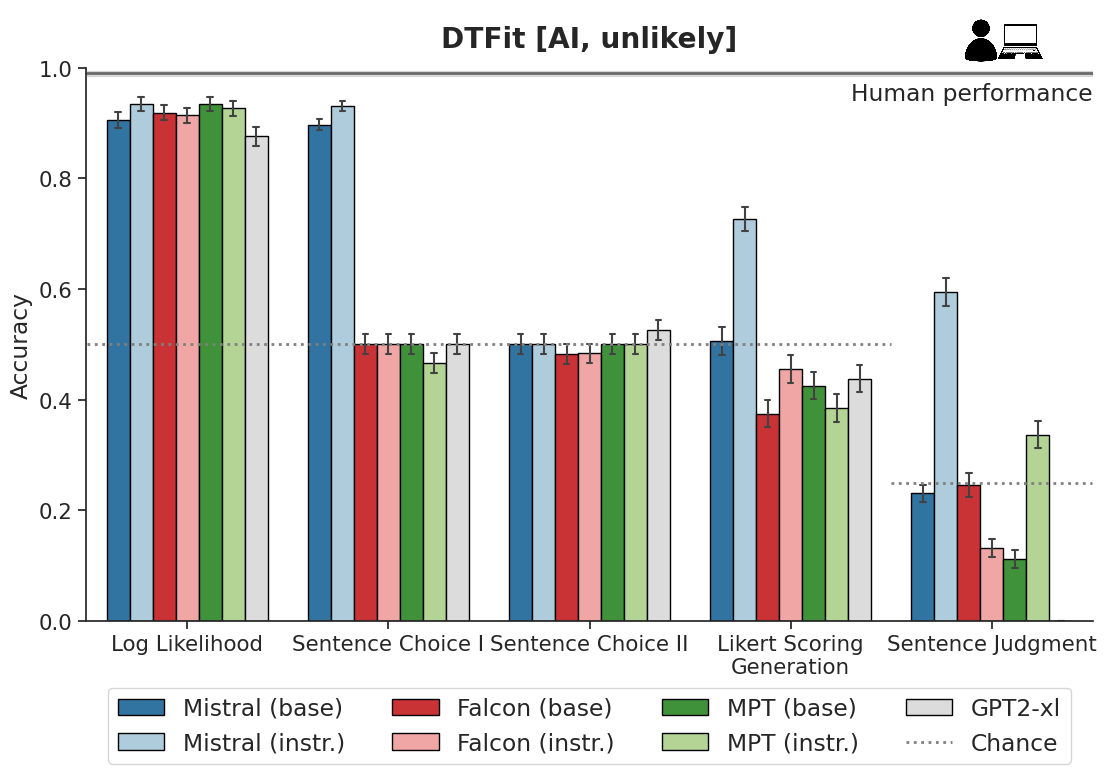

In [27]:
plt.figure(figsize=(13, 7))

ax = sns.barplot(data=plot_df, x="task", y="Accuracy", hue="model", edgecolor='black', linewidth=1, errorbar="se",
                 palette=MODEL_PAL, capsize=0.2, err_kws={'linewidth': 1.5})

# Extract text from each Text object
xticklabels = [label.get_text() for label in ax.get_xticklabels()]

new_labels = []
for task in xticklabels:
    if (TASKSET == "GENERATION") & ("generation" in task):
        new_labels.append(f"{BETTER_TASK_NAMES['_'.join(task.split('_')[:-1])]}\n[{task.split('_')[-1]}]")
    elif TASKSET == "QUERY_COMPARISON":
        new_labels.append(f"{BETTER_TASK_NAMES['_'.join(task.split('_')[:-1])]}\n['{task.split('_')[-1]}']")
    else:
        new_labels.append(BETTER_TASK_NAMES[task])

ax.set_xticklabels(labels = new_labels, rotation=0, fontweight='normal')
ax.set_xlabel("")

# add chance level lines
x_range = ax.get_xlim()
if "sentence_judge" in xticklabels:
    # Plot a dotted line at height 0.5
    ax.plot([x_range[0] , x_range[1] - 1], [0.5, 0.5], linestyle=":", color="gray", alpha=1, linewidth=2, label="Chance")
    # Plot a dotted line at height 0.25
    ax.plot([x_range[1] - 1 , x_range[1]], [0.25, 0.25], linestyle=":", color="gray", alpha=1, linewidth=2)
else:
    ax.axhline(y=0.5, linestyle=":", color="gray", alpha=1, linewidth=2, label="Chance")

# Fix ylim
plt.ylim(0,1)

human_baseline = human_values.loc[human_values.corpus == "DTFit"].Mean_Accuracy.item()
human_error = human_values.loc[human_values.corpus == "DTFit"].SEM_Accuracy.item()

# Calculate the y-range for the shaded area
ymin = human_baseline - human_error
ymax = human_baseline + human_error
# Add shaded error around the horizontal line
ax.fill_betweenx(y=[ymin, ymax], x1=x_range[0], x2=x_range[1], color=MODEL_PAL["human"], alpha=0.2)
ax.axhline(y=human_baseline, linestyle="-", color=MODEL_PAL["human"], alpha=1, linewidth=2) #, label="human") #MODEL_PAL["human"]
# Add line annotation
ax.text(x_range[1], ymin - 0.01, "Human performance", verticalalignment='top', horizontalalignment='right') #,
        #bbox=dict(facecolor=MODEL_PAL["human"], alpha=0.2, boxstyle='round,pad=0.2'))


# Add title
# Load the icon image
aa_icon_path = 'animate-animate.png'
ai_icon_path = 'animate-inanimate-laptop.png'

if TASKSET == "MAIN":
    title = "DTFit [AI, unlikely]"
elif TASKSET == "GENERATION":
    title = "Generation Prompting (DTFit [AI, unlikely])"
elif TASKSET == "QUERY_COMPARISON":
    title = "Query Comparison (DTFit [AI, unlikely])"   

ax.set_title(title, fontweight='bold', fontsize="large", pad=15)
icon = mpimg.imread(ai_icon_path)

# Create an offset image
imagebox = OffsetImage(icon, zoom=0.03)
imagebox.image.axes = ax

# Create an AnnotationBbox
ab = AnnotationBbox(imagebox, (0.91, 1.05), xycoords='axes fraction', frameon=False)

# Add the icon to the subplot
ax.add_artist(ab)

# Style and add legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [PRETTYNAMES[elm] if elm in PRETTYNAMES else elm for elm in labels]

if TASKSET == "MAIN":
    legend_loc = -0.28
elif TASKSET == "QUERY_COMPARISON":
    legend_loc = -0.28
else:
    legend_loc = -0.32
    # Put a legend to the right of the current axis
ax.legend(handles, new_labels, loc='lower center', bbox_to_anchor=(0.5, legend_loc),
          ncol=4, frameon=True, fontsize='medium')

plt.margins(x=0.001)
    
# Adjust the layout and display the plot
plt.subplots_adjust(top=0.9)  # Adjust the top of the subplots for the suptitle

plt.savefig(f'figures/PromptChoice.{DATASET}.{TASKSET}.svg', dpi=280, bbox_inches="tight")
plt.savefig(f'figures/PromptChoice.{DATASET}.{TASKSET}.png', dpi=280, bbox_inches="tight")

plt.show()

In [28]:
from scipy.stats import binomtest, chi2_contingency
from statsmodels.stats.multitest import multipletests

def assign_significance_labels(pvals):
    return ["***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "n.s." for p in pvals]

def calculate_binom_pval(num_correct, num_total, task):
    if task == "sentence_judge":
        p=0.25
    else:
        p=0.5
    return binomtest(k=num_correct, n=num_total, p=p).pvalue

for task in task_order:
    print(task.upper())
    sub_df = plot_df.loc[plot_df["task"] == task]
        # Calculate p-values for binomial test
    dat_binchoice_summary = sub_df.groupby('model').agg(NumCorrect=('Accuracy', 'sum'), NumTotal=('Accuracy', 'count')) \
        .reset_index() \
        .assign(AccuracyScore=lambda x: x['NumCorrect'] / x['NumTotal'])

    dat_binchoice_summary['pVal'] = dat_binchoice_summary.apply(lambda row: calculate_binom_pval(row['NumCorrect'], row['NumTotal'], task), axis=1)
    dat_binchoice_summary['pValAdjusted'] = multipletests(dat_binchoice_summary['pVal'], method='fdr_bh')[1]
    dat_binchoice_summary['significance'] = assign_significance_labels(dat_binchoice_summary['pValAdjusted'])
    print(dat_binchoice_summary)
    print("\n\n")

LOGPROBS
                      model  NumCorrect  NumTotal  AccuracyScore  \
0           Mistral-7B-v0.1         358       395       0.906329   
1  Mistral-7B-Instruct-v0.1         369       395       0.934177   
2                 falcon-7b         363       395       0.918987   
3        falcon-7b-instruct         361       395       0.913924   
4                    mpt-7b         369       395       0.934177   
5           mpt-7b-instruct         366       395       0.926582   
6                   gpt2-xl         346       395       0.875949   

           pVal  pValAdjusted significance  
0  4.175373e-67  4.871269e-67          ***  
1  9.254456e-79  3.239059e-78          ***  
2  3.503476e-72  6.131083e-72          ***  
3  4.130286e-70  5.782400e-70          ***  
4  9.254456e-79  3.239059e-78          ***  
5  2.123542e-75  4.954931e-75          ***  
6  3.628780e-56  3.628780e-56          ***  



SENTENCE_COMPARISON
                      model  NumCorrect  NumTotal  AccuracyScor